In [1]:
# Dependencies
%matplotlib notebook
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [3]:
# Create an engine to a SQLite database file called `hawaii.sqlite`
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create a connection to the engine called `conn`
conn = engine.connect()

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save a reference to the measurements table as `Measurement`
Measurement = Base.classes.measurement

# Save a reference to the stations table as `Station`
Station = Base.classes.station

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use `engine.execute` to select and display the first 10 rows from the table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Last date entry in the data table 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [10]:
# Last 12 months of data, last date 
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [11]:
# View the data
session.query(Measurement.date, Measurement.prcp).limit(10).all()

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None),
 ('2010-01-07', 0.06),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.0),
 ('2010-01-11', 0.01)]

In [12]:
# Query to retrieve the last 12 months of precipitation data
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [13]:
# Load the query results into a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


<IPython.core.display.Javascript object>


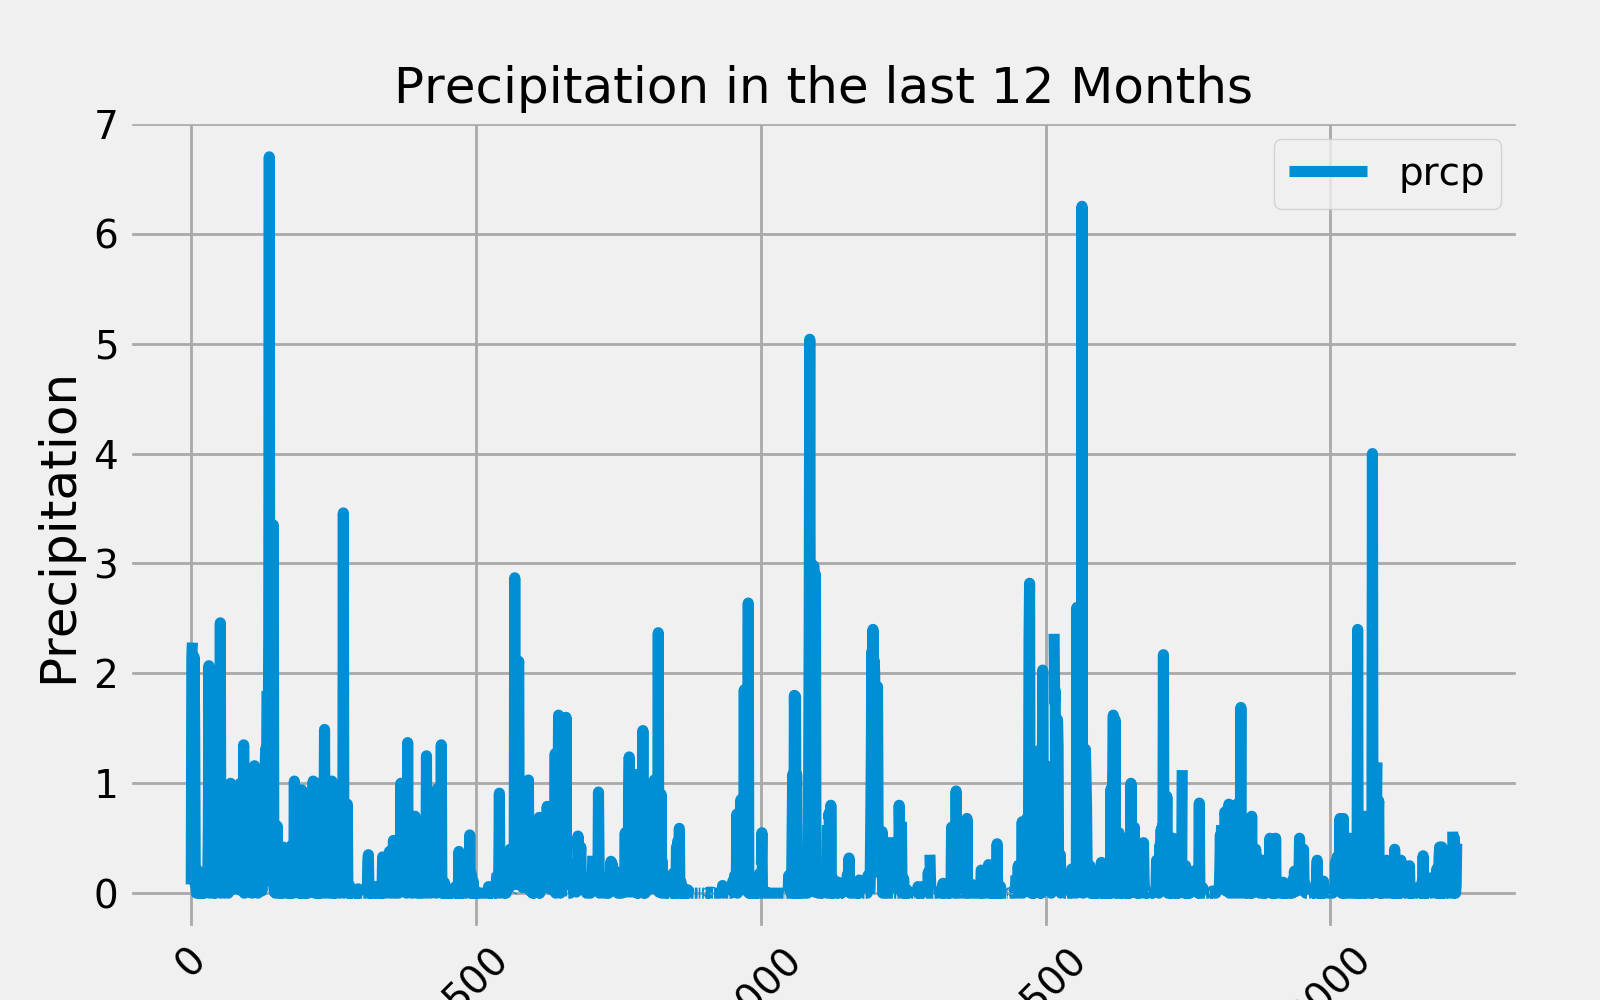

In [14]:
# Plot the dataframe
rain_df.plot(figsize=(8,5))
plt.tight_layout

plt.xticks(rotation="45")

plt.title("Precipitation in the last 12 Months", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Precipitation", fontsize=18)

plt.grid(color='darkgray')
plt.rcParams['axes.facecolor'] = 'lightgray'

plt.show()

In [15]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# The above data is the precipitation from each weather station for each date. The data should be graphed for the 
# average amount of the rain for each date from all the weather stations. See the next graph.
# Load the results into a pandas dataframe
precipitation_sum = pd.DataFrame(rain, columns=['Date', 'Prcp'])

# Change the date to a datetime format
precipitation_sum['Date'] = pd.to_datetime(precipitation_sum['Date'], format='%Y/%m/%d')

# Precipitation_df.set_index('Date').head()
# Total for each station for each date and set the index as the date
precipitation_totals = precipitation_sum.pivot_table(precipitation_sum, index=['Date'], aggfunc='mean')
precipitation_totals.head()

,Prcp
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<IPython.core.display.Javascript object>


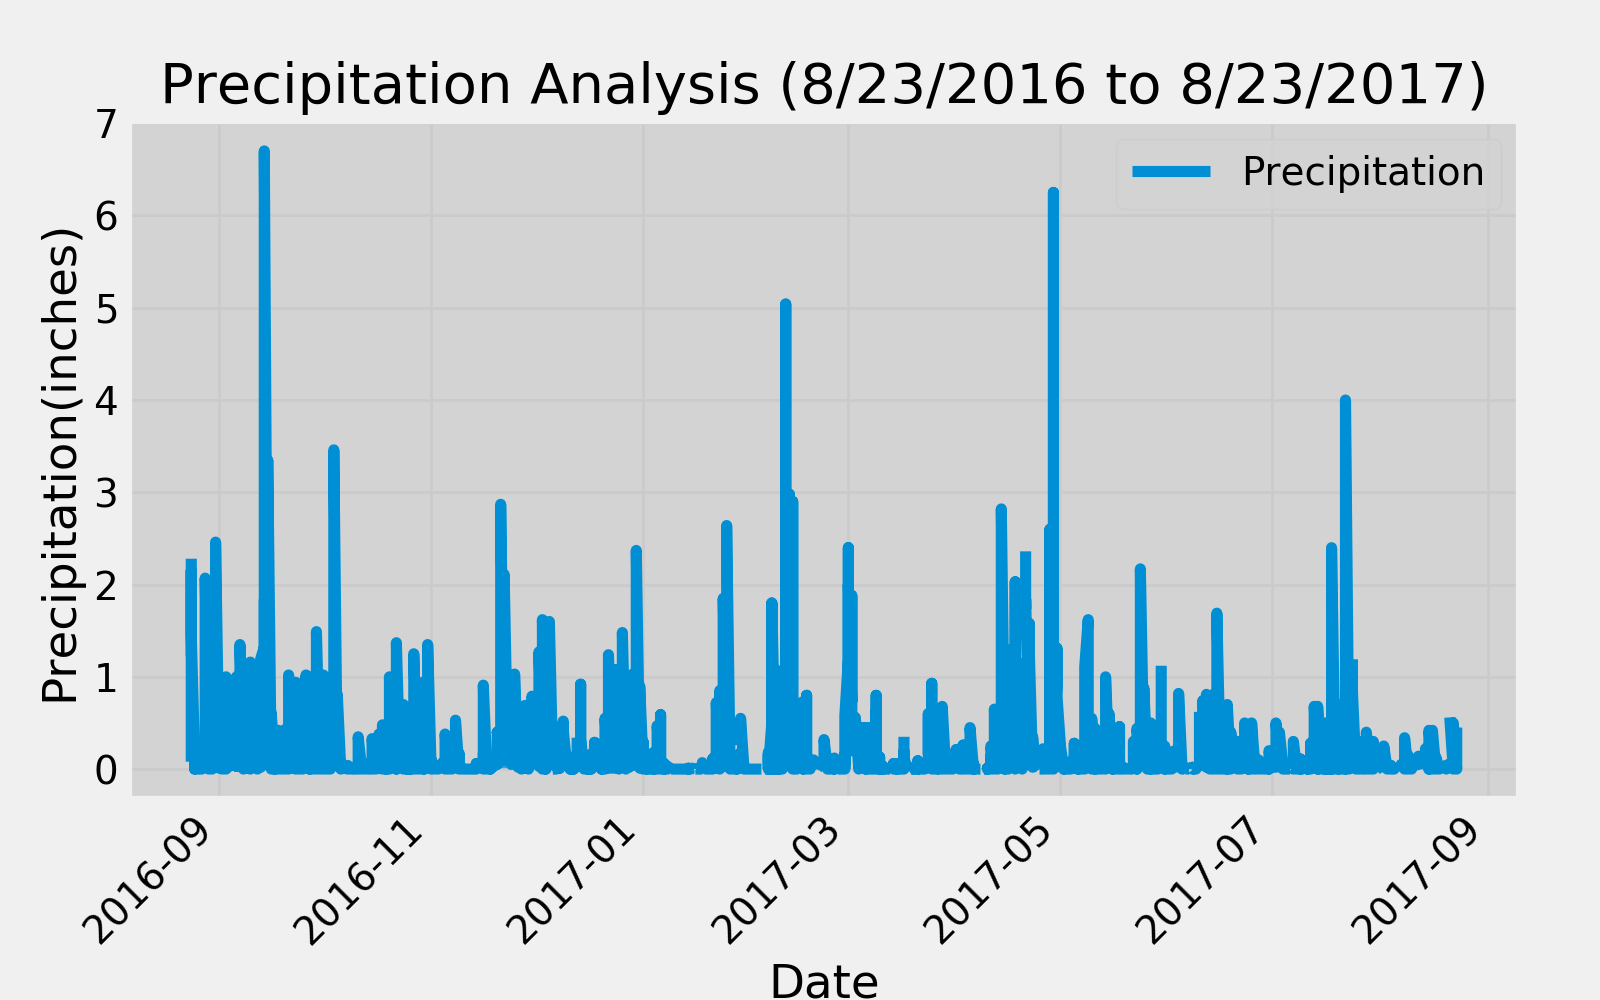

In [17]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
precipitation_sum.plot('Date', 'Prcp',figsize=(8,5))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/23/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [18]:
# Summary statistics for the precipitation dataframe
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Station Analysis

In [20]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [21]:
# What are the most active stations?
# List the stations and the counts in descending order
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("All of the Stations (in descending order) with their number of observations are:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

All of the Stations (in descending order) with their number of observations are:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [22]:
# Which station has the highest number of observations?
station_id = busy_station[0][0]
station_name = session.query(Station.name).filter(Station.station==busy_station[0][0]).all()
print(f'The highest number of observations come from {station_name[0][0]}')

The highest number of observations come from WAIHEE 837.5, HI US


In [23]:
# Choose the station with the highest number of temperature observations
# Query the last 12 months of temperature observation data for the busiest station
tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station==station_id).\
order_by(Measurement.date).statement

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

,tobs,station
0,77.0,USC00519281
1,77.0,USC00519281
2,80.0,USC00519281
3,80.0,USC00519281
4,75.0,USC00519281


<IPython.core.display.Javascript object>


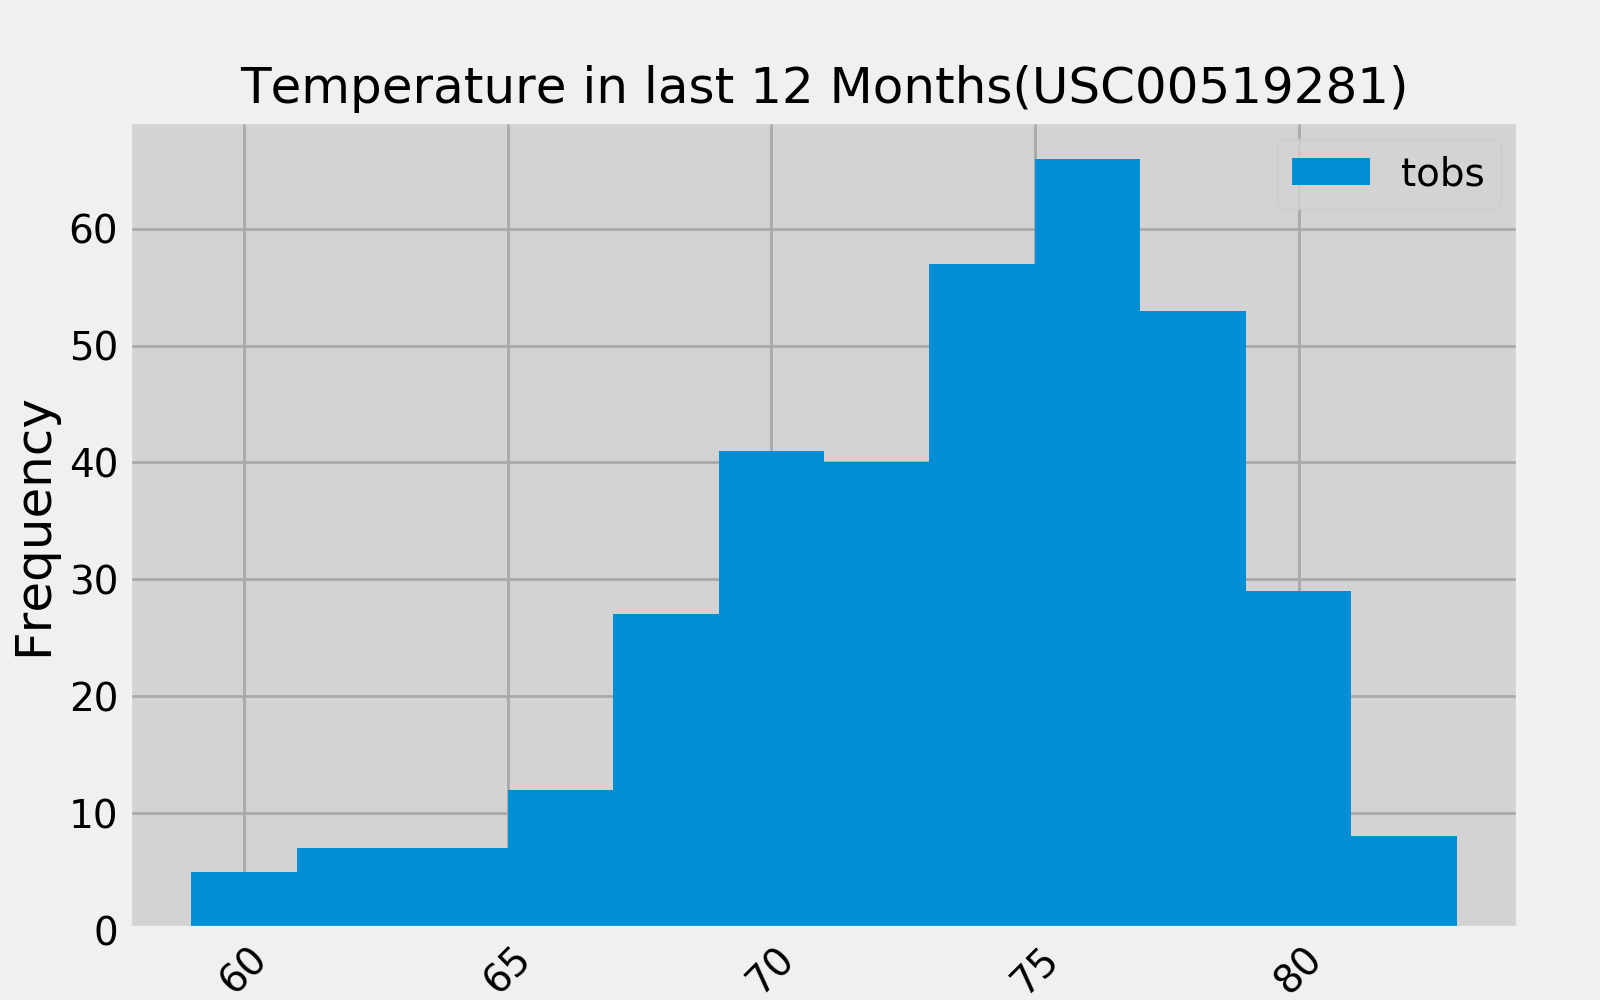

In [24]:
# Plot the temperature data in a histogram with 12 bins
tobs_df.plot.hist(bins=12, figsize=(8,5))
plt.tight_layout

plt.xticks(rotation="45")

plt.title("Temperature in last 12 Months(USC00519281)", fontsize=18)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

plt.grid(color='darkgray')
plt.rcParams['axes.facecolor'] = 'lightgray'

plt.show()

In [25]:
# Temperature Analysis

In [26]:
# Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` # Write  
# and return the minimum, average, and maximum temperatures for that range of dates.

import datetime as datetime

# Define a function
def calc_temps(start_date, end_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()

# Call the function with user input values for start date and end date
trip_temp_min, trip_temp_avg, trip_temp_max = calc_temps(str(input("Enter a Start Date (yyyy-mm-dd): ")), \
                                                         str(input("Enter an End Date (yyyy-mm-dd): ")))[0]
print(trip_temp_min, trip_temp_avg, trip_temp_max)
print("Minimum Temperature: {}".format(trip_temp_min))
print("Average Temperature: {}".format(trip_temp_avg))
print("Maximum Temperature: {}".format(trip_temp_max))

Enter a Start Date (yyyy-mm-dd): 2016-08-23
Enter an End Date (yyyy-mm-dd): 2017-08-23
58.0 74.59058295964125 87.0
Minimum Temperature: 58.0
Average Temperature: 74.59058295964125
Maximum Temperature: 87.0


In [27]:
# Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the 
# matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

import datetime as datetime

# Trip start date from the user
start_year = input("Enter the Trip Start Date(yyyy): ")
start_month = input("Enter the Trip Start Date(mm): ")
start_day = input("Enter the Trip Start Date(dd): ")

# Trip end date from the user
end_year = input("Enter the Trip End Date(yyyy): ")
end_month = input("Enter the TripEnd Date(mm): ")
end_day = input("Enter the Trip End Date(dd): ")

# Calculate the dates from the previous year
prev_year_start_date = datetime.date(int(start_year), int(start_month), int(start_day)) - datetime.timedelta(days=365)
prev_year_end_date = datetime.date(int(end_year), int(end_month), int(end_day)) - datetime.timedelta(days=365)

print(prev_year_start_date)
print(f"Temperatures for the previous year from {prev_year_start_date} to {prev_year_end_date}")

# Function with the trip start and end dates from the previous year
prev_year_temp_min, prev_year_temp_avg, prev_year_temp_max = calc_temps(prev_year_start_date, prev_year_end_date)[0]

print("Previous year Minimum Temperature: {}".format(prev_year_temp_min))
print("Previous year Average Temperature: {}".format(prev_year_temp_avg))
print("Previous year Maximum Temperature: {}".format(prev_year_temp_max))

Enter the Trip Start Date(yyyy): 2016
Enter the Trip Start Date(mm): 08
Enter the Trip Start Date(dd): 23
Enter the Trip End Date(yyyy): 2017
Enter the TripEnd Date(mm): 08
Enter the Trip End Date(dd): 23
2015-08-24
Temperatures for the previous year from 2015-08-24 to 2016-08-23
Previous year Minimum Temperature: 56.0
Previous year Average Temperature: 74.43899317406144
Previous year Maximum Temperature: 86.0


<IPython.core.display.Javascript object>


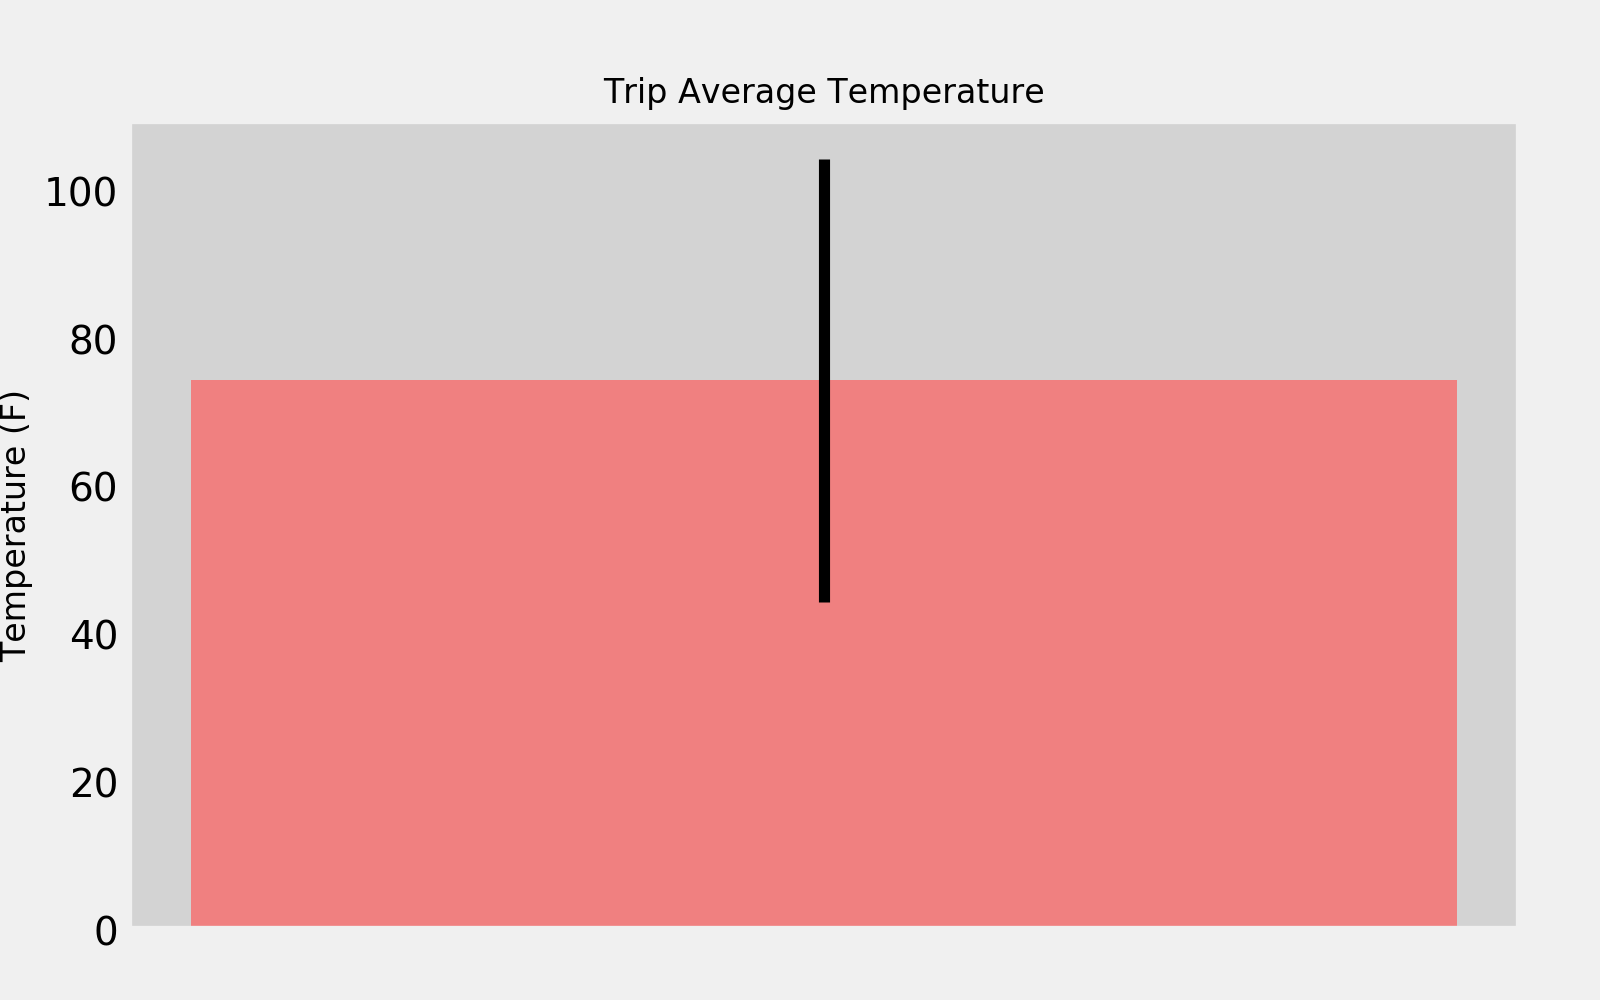

In [28]:
# Plot the min, avg, and max temperature from your previous query as a bar chart
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
plt.figure(figsize=(8,5))

yerr= prev_year_temp_max - prev_year_temp_min
plt.bar("", prev_year_temp_avg, yerr=yerr, color="lightcoral")

plt.title("Trip Average Temperature", fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('Temperature (F)', fontsize=12)

plt.grid()

plt.show()

In [29]:
start_date  = '2017-06-28'
end_date = '2017-07-07'
vacay_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Load the results into a pandas dataframe
vacay_temps = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temps.head()

,Date,Tobs
0,2017-06-28,79.0
1,2017-06-29,79.0
2,2017-06-30,75.0
3,2017-07-01,80.0
4,2017-07-02,80.0


In [30]:
# Summary statistics to check if the min, max and avg temp are correct
vacay_temps.describe()

,Tobs
count,60.000000
mean,77.716667
std,2.511611
min,74.000000
25%,76.000000
50%,77.000000
75%,79.250000
max,87.000000


In [31]:
# Calculate the rainfall per weather station using the previous year's matching dates.
rainfall_per_station = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                            group_by(Measurement.station).\
                            filter(Measurement.date >= prev_year_start_date).\
                            filter(Measurement.date <= prev_year_end_date).all()
rainfall_per_station

[('USC00511918', 3.9499999999999997),
 ('USC00513117', 72.25999999999999),
 ('USC00514830', 42.35999999999999),
 ('USC00516128', 177.55999999999997),
 ('USC00517948', 4.5600000000000005),
 ('USC00518838', 0.0),
 ('USC00519281', 105.70000000000006),
 ('USC00519397', 23.78),
 ('USC00519523', 55.51000000000001)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
